In [1]:
import os
os.chdir("/Users/asahoo/repos/PASTIS")
import time
from shutil import copy

from astropy.io import fits
import astropy.units as u
import hcipy
import numpy as np

import pastis.util as util    
from pastis.config import CONFIG_PASTIS 
from pastis.e2e_simulators.luvoir_imaging import LuvoirA_APLC 
from pastis.e2e_simulators.generic_segmented_telescopes import SegmentedAPLC
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import griddata

import exoscene.image
import exoscene.star
import exoscene.planet
from exoscene.planet import Planet

### Define and create directory

In [2]:
root_dir = "/Users/asahoo/Desktop/data_repos/harris_data"
repo_dir = "/Users/asahoo/repos/PASTIS"
coronagraph_design = 'medium'
overall_dir = util.create_data_path(root_dir, telescope='luvoir_'+coronagraph_design)
resDir = os.path.join(overall_dir, 'matrix_numerical')
print(resDir)


# Create necessary directories if they don't exist yet
os.makedirs(resDir, exist_ok=True)
os.makedirs(os.path.join(resDir, 'OTE_images'), exist_ok=True)
os.makedirs(os.path.join(resDir, 'psfs'), exist_ok=True)

/Users/asahoo/Desktop/data_repos/harris_data

/Users/asahoo/Desktop/data_repos/harris_data/2021-08-30T15-19-15_luvoir_medium/matrix_numerical


### Read from configfile 

In [3]:
nb_seg = CONFIG_PASTIS.getint('LUVOIR', 'nb_subapertures')
wvln = CONFIG_PASTIS.getfloat('LUVOIR', 'lambda') * 1e-9  # m #this doesn't matter, luvoir.wvln
diam = CONFIG_PASTIS.getfloat('LUVOIR', 'diameter')  # m
nm_aber = CONFIG_PASTIS.getfloat('LUVOIR', 'calibration_aberration') * 1e-9   # m
sampling = CONFIG_PASTIS.getfloat('LUVOIR', 'sampling')


optics_path_in_repo = CONFIG_PASTIS.get('LUVOIR', 'optics_path_in_repo')
aper_path = CONFIG_PASTIS.get('LUVOIR','aperture_path_in_optics')
aper_ind_path = CONFIG_PASTIS.get('LUVOIR', 'indexed_aperture_path_in_optics')
aper_read = hcipy.read_fits(os.path.join(repo_dir,optics_path_in_repo,aper_path))
aper_ind_read = hcipy.read_fits(os.path.join(repo_dir,optics_path_in_repo,aper_ind_path))
z_pup_downsample = CONFIG_PASTIS.getfloat('numerical', 'z_pup_downsample') 

### Load aperture files to make segmented mirror

In [4]:
pupil_grid = hcipy.make_pupil_grid(dims=aper_ind_read.shape[0], diameter=15)
aper = hcipy.Field(aper_read.ravel(), pupil_grid)
aper_ind = hcipy.Field(aper_ind_read.ravel(), pupil_grid)
wf_aper = hcipy.Wavefront(aper, wvln)

# Load segment positions from fits header
hdr = fits.getheader(os.path.join(repo_dir,optics_path_in_repo,aper_ind_path))

poslist = []
for i in range(nb_seg):
    segname = 'SEG' + str(i+1)
    xin = hdr[segname + '_X']
    yin = hdr[segname + '_Y']
    poslist.append((xin, yin))
    
poslist = np.transpose(np.array(poslist))
seg_pos = hcipy.CartesianGrid(hcipy.UnstructuredCoords(poslist))

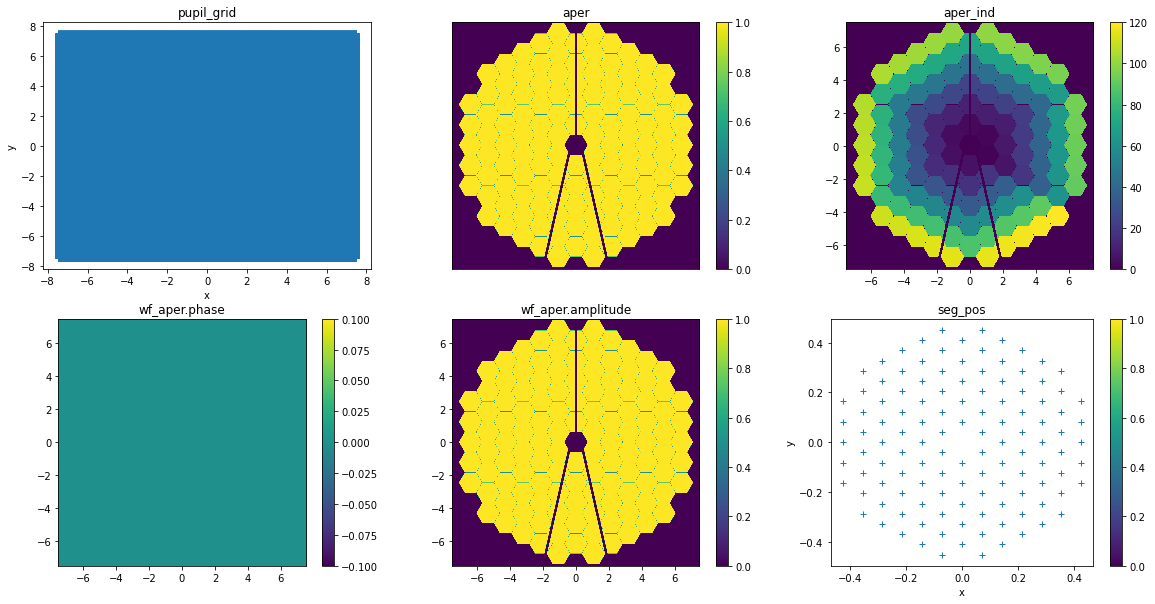

In [5]:
plt.figure(figsize=(20,10))

plt.subplot(2,3,1)
plt.title("pupil_grid")
plt.plot(pupil_grid.x, pupil_grid.y, '+')
plt.xlabel('x')
plt.ylabel('y')

plt.subplot(2,3,2)
plt.title("aper")
hcipy.imshow_field(aper)
plt.tick_params(top=False, bottom=False, left=False, right=False,
                labelleft=False, labelbottom=False)
plt.colorbar()

plt.subplot(2,3,3)
plt.title("aper_ind")
hcipy.imshow_field(aper_ind)
plt.colorbar()

plt.subplot(2,3,4)
plt.title("wf_aper.phase")
hcipy.imshow_field(wf_aper.phase)
plt.colorbar()

plt.subplot(2,3,5)
plt.title("wf_aper.amplitude")
hcipy.imshow_field(wf_aper.amplitude)
plt.colorbar()

plt.subplot(2,3,6)
plt.title("seg_pos")
plt.plot(seg_pos.x, seg_pos.y, '+')
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar()

### Instantiate LUVOIR

In [6]:
optics_input = os.path.join(util.find_repo_location(), CONFIG_PASTIS.get('LUVOIR', 'optics_path_in_repo'))
luvoir = LuvoirA_APLC(optics_input, coronagraph_design, sampling)

/opt/miniconda3/envs/pastis_global/lib/python3.7/site-packages/hcipy/field/cartesian_grid.py:74: UserWarning: No automatic weights could be calculated for this grid.
  self.weights *= np.abs(scale)**self.ndim


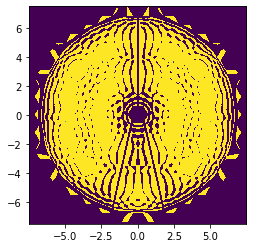

In [7]:
hcipy.imshow_field(luvoir.apodizer)

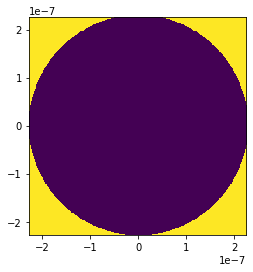

In [8]:
hcipy.imshow_field(luvoir.fpm)

In [9]:
N_pup_z = np.int(luvoir.pupil_grid.shape[0] / z_pup_downsample) #N_pup_z = 100
grid_zernike = hcipy.field.make_pupil_grid(N_pup_z, diameter=luvoir.diam)

Text(0, 0.5, 'y')

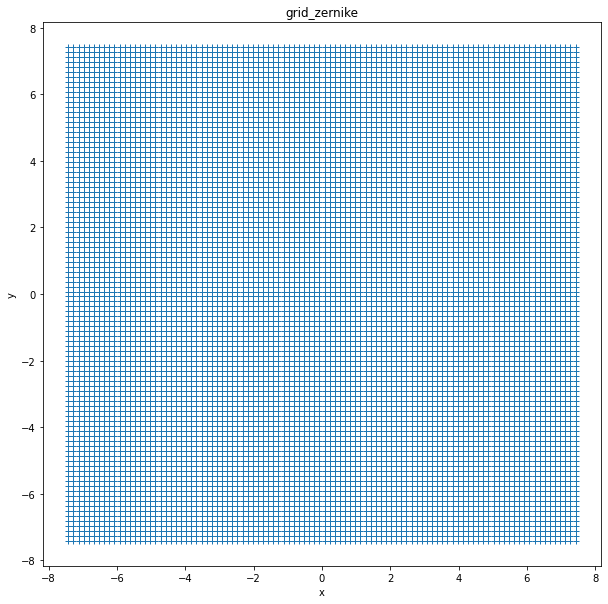

In [10]:
plt.figure(figsize=(10,10))
plt.title("grid_zernike") #hcipy cartesian grid
plt.plot(grid_zernike.x, grid_zernike.y, '+')
plt.xlabel('x')
plt.ylabel('y')

### load thermal modes files

In [11]:
filepath = "/Users/asahoo/repos/PASTIS/Jupyter Notebooks/LUVOIR/Sensitivities2.xlsx"
pad_orientation = np.pi/2*np.ones(nb_seg)
#pad_orientation = np.zeros(nb_seg)

### create harris deformabale mirror

In [12]:
luvoir.create_segmented_harris_mirror(filepath,pad_orientation, thermal = True,mechanical=False,other=False) 
luvoir.harris_sm

### creating single segment

In [13]:
segment = hcipy.hexagonal_aperture(luvoir.segment_circumscribed_diameter, np.pi/2) #function
segment_sampled = hcipy.evaluate_supersampled(segment,luvoir.pupil_grid, 10) #hcipy field

### creating nb_seg segments

In [14]:
aper2, segs2 = hcipy.make_segmented_aperture(segment,luvoir.seg_pos, segment_transmissions=1, return_segments=True)
luvoir_segmented_pattern = hcipy.evaluate_supersampled(aper2, luvoir.pupil_grid, 10)
seg_evaluated = []
for seg_tmp in segs2:
    tmp_evaluated = hcipy.evaluate_supersampled(seg_tmp, luvoir.pupil_grid, 1)
    seg_evaluated.append(tmp_evaluated)

### Plotting Harris_mode

In [15]:
df = pd.read_excel(filepath)
valuesA = np.asarray(df.a)
valuesB = np.asarray(df.b)
valuesC = np.asarray(df.c)
valuesD = np.asarray(df.d)
valuesE = np.asarray(df.e)
valuesF = np.asarray(df.f)
valuesG = np.asarray(df.g)
valuesH = np.asarray(df.h)
valuesI = np.asarray(df.i)
valuesJ = np.asarray(df.j)
valuesK = np.asarray(df.k)

seg_x = np.asarray(df.X)
seg_y = np.asarray(df.Y)

harris_seg_diameter = np.max([np.max(seg_x) - np.min(seg_x), np.max(seg_y) - np.min(seg_y)])
pup_dims = luvoir.pupil_grid.dims
x_grid = np.asarray(df.X) * luvoir.segment_circumscribed_diameter /harris_seg_diameter
y_grid = np.asarray(df.Y) * luvoir.segment_circumscribed_diameter /harris_seg_diameter
points = np.transpose(np.asarray([x_grid, y_grid]))

seg_evaluated = luvoir._create_evaluated_segment_grid()

def _transform_harris_mode(values, xrot, yrot, points, seg_evaluated, seg_num):
    """ Take imported Harris mode data and transform into a segment mode on our aperture. """
    zval = griddata(points, values, (xrot, yrot), method='linear')
    zval[np.isnan(zval)] = 0
    zval = zval.ravel() * seg_evaluated[seg_num]
    return zval

harris_base_thermal = []
for seg_num in range(0, luvoir.nseg):
    grid_seg = luvoir.pupil_grid.shifted(-luvoir.seg_pos[seg_num])
    x_line_grid = np.asarray(grid_seg.x)
    y_line_grid = np.asarray(grid_seg.y)
    
# Rotate the modes grids according to the orientation of the mounting pads
phi = pad_orientation[seg_num]
x_rotation = x_line_grid * np.cos(phi) + y_line_grid * np.sin(phi)
y_rotation = -x_line_grid * np.sin(phi) + y_line_grid * np.cos(phi)

# Transform all needed Harris modes from data to modes on our segmented aperture
ZA = _transform_harris_mode(valuesA, x_rotation, y_rotation, points, seg_evaluated, seg_num)
ZB = _transform_harris_mode(valuesB, x_rotation, y_rotation, points, seg_evaluated, seg_num)
ZC = _transform_harris_mode(valuesC, x_rotation, y_rotation, points, seg_evaluated, seg_num)
ZD = _transform_harris_mode(valuesD, x_rotation, y_rotation, points, seg_evaluated, seg_num)
ZE = _transform_harris_mode(valuesE, x_rotation, y_rotation, points, seg_evaluated, seg_num)
ZF = _transform_harris_mode(valuesF, x_rotation, y_rotation, points, seg_evaluated, seg_num)
ZG = _transform_harris_mode(valuesG, x_rotation, y_rotation, points, seg_evaluated, seg_num)
ZH = _transform_harris_mode(valuesH, x_rotation, y_rotation, points, seg_evaluated, seg_num)
ZI = _transform_harris_mode(valuesI, x_rotation, y_rotation, points, seg_evaluated, seg_num)
ZJ = _transform_harris_mode(valuesJ, x_rotation, y_rotation, points, seg_evaluated, seg_num)
ZK = _transform_harris_mode(valuesK, x_rotation, y_rotation, points, seg_evaluated, seg_num)

harris_base_thermal.append([ZA, ZB, ZC, ZD, ZE, ZF, ZG, ZH, ZI, ZJ, ZK])

### Flatten all DMs and create unaberrated reference PSF

In [16]:
n_harris = luvoir.harris_sm.num_actuators #int = 5*120 =600
harris_mode =np.zeros(n_harris)
luvoir.harris_sm.actuators = harris_mode #setting all actuators to be zero

### Calculate the unaberrated coro and direct PSFs in INTENSITY

In [17]:
unaberrated_coro_psf, ref = luvoir.calc_psf(ref=True, display_intermediate=False, norm_one_photon=True)

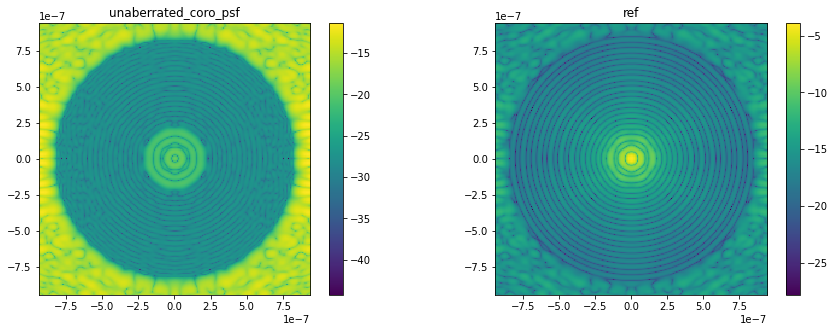

In [18]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.title("unaberrated_coro_psf")
hcipy.imshow_field(np.log(np.abs(unaberrated_coro_psf)))
plt.colorbar()

plt.subplot(1,2,2)
plt.title("ref")
hcipy.imshow_field(np.log(np.abs(ref)))
plt.colorbar()

In [19]:
norm = np.max(ref)
print(norm)
dh_intensity = (unaberrated_coro_psf / norm) * luvoir.dh_mask
contrast_floor = np.mean(dh_intensity[np.where(luvoir.dh_mask != 0)])
print(f'contrast floor: {contrast_floor}')

0.02030478617075724
contrast floor: 3.927653745791342e-11


Text(0.5, 1.0, 'dh_intensity')

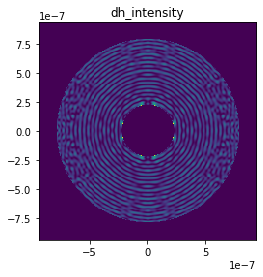

In [20]:
hcipy.imshow_field(dh_intensity)
plt.title("dh_intensity")

### Calculate the unaberrated coro and direct PSFs in E-FIELDS

In [21]:
# Calculate the unaberrated coro and direct PSFs in E-FIELDS
nonaberrated_coro_psf, ref, efield = luvoir.calc_psf(ref=True, display_intermediate=False, return_intermediate='efield',norm_one_photon=True)
Efield_ref = nonaberrated_coro_psf.electric_field

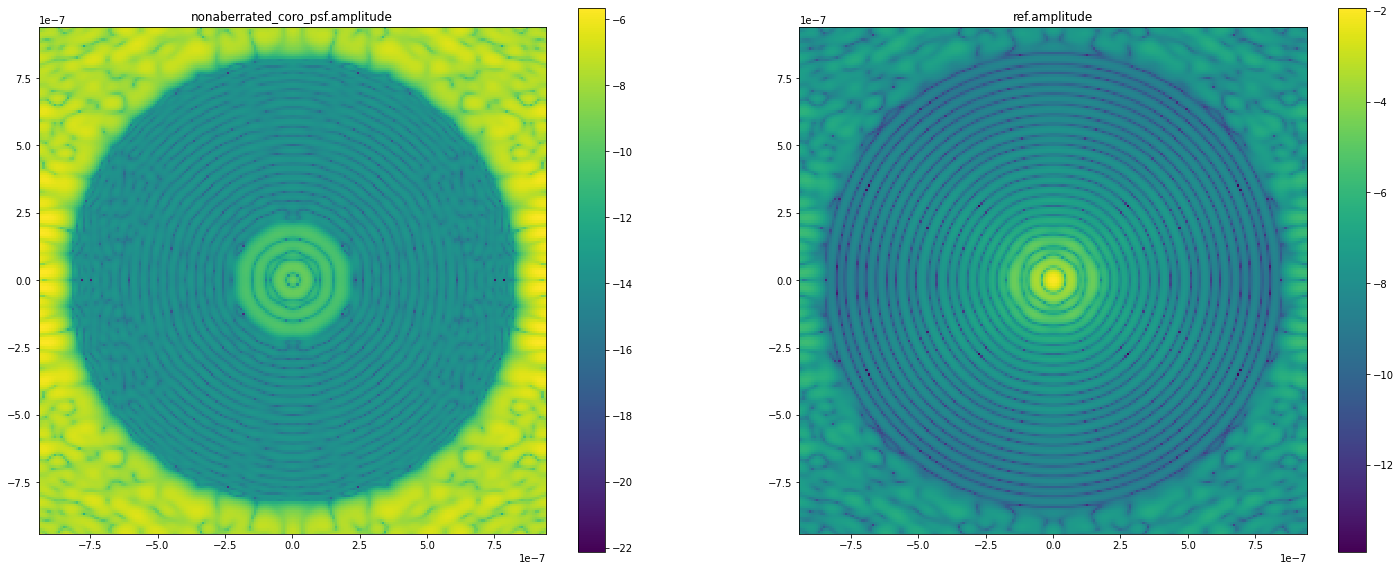

In [22]:
plt.figure(figsize=(25, 10))

plt.subplot(1,2,1)
hcipy.imshow_field(np.log(np.abs(nonaberrated_coro_psf.amplitude)))
plt.title("nonaberrated_coro_psf.amplitude")
plt.colorbar()

plt.subplot(1,2,2)
hcipy.imshow_field(np.log(np.abs(ref.amplitude)))
plt.title("ref.amplitude")
plt.colorbar()

In [23]:
print('Generating the E-fields for harris modes in science plane')
print(f'Calibration aberration used: {nm_aber} m')


Generating the E-fields for harris modes in science plane
Calibration aberration used: 1e-09 m


In [24]:
start_time = time.time()
focus_fieldS = []
focus_fieldS_Re = []
focus_fieldS_Im = []
harris_mode = np.zeros(n_harris)

In [25]:
for pp in range(0, n_harris):
    print(f'Working on mode {pp}/{n_harris}')
    
    # Apply calibration aberration to used mode
    harris_mode = np.zeros(n_harris)
    harris_mode[pp] = (nm_aber)/2 
    luvoir.harris_sm.actuators  = harris_mode
    
    # Calculate coronagraphic E-field and add to lists
    aberrated_coro_psf, inter = luvoir.calc_psf(display_intermediate=False, return_intermediate='efield',norm_one_photon=True)
    focus_field1 = aberrated_coro_psf
    focus_fieldS.append(focus_field1)
    focus_fieldS_Re.append(focus_field1.real)
    focus_fieldS_Im.append(focus_field1.imag)

Working on mode 0/600
Working on mode 1/600
Working on mode 2/600
Working on mode 3/600
Working on mode 4/600
Working on mode 5/600
Working on mode 6/600
Working on mode 7/600
Working on mode 8/600
Working on mode 9/600
Working on mode 10/600
Working on mode 11/600
Working on mode 12/600
Working on mode 13/600
Working on mode 14/600
Working on mode 15/600
Working on mode 16/600
Working on mode 17/600
Working on mode 18/600
Working on mode 19/600
Working on mode 20/600
Working on mode 21/600
Working on mode 22/600
Working on mode 23/600
Working on mode 24/600
Working on mode 25/600
Working on mode 26/600
Working on mode 27/600
Working on mode 28/600
Working on mode 29/600
Working on mode 30/600
Working on mode 31/600
Working on mode 32/600
Working on mode 33/600
Working on mode 34/600
Working on mode 35/600
Working on mode 36/600
Working on mode 37/600
Working on mode 38/600
Working on mode 39/600
Working on mode 40/600
Working on mode 41/600
Working on mode 42/600
Working on mode 43/60

Working on mode 346/600
Working on mode 347/600
Working on mode 348/600
Working on mode 349/600
Working on mode 350/600
Working on mode 351/600
Working on mode 352/600
Working on mode 353/600
Working on mode 354/600
Working on mode 355/600
Working on mode 356/600
Working on mode 357/600
Working on mode 358/600
Working on mode 359/600
Working on mode 360/600
Working on mode 361/600
Working on mode 362/600
Working on mode 363/600
Working on mode 364/600
Working on mode 365/600
Working on mode 366/600
Working on mode 367/600
Working on mode 368/600
Working on mode 369/600
Working on mode 370/600
Working on mode 371/600
Working on mode 372/600
Working on mode 373/600
Working on mode 374/600
Working on mode 375/600
Working on mode 376/600
Working on mode 377/600
Working on mode 378/600
Working on mode 379/600
Working on mode 380/600
Working on mode 381/600
Working on mode 382/600
Working on mode 383/600
Working on mode 384/600
Working on mode 385/600
Working on mode 386/600
Working on mode 

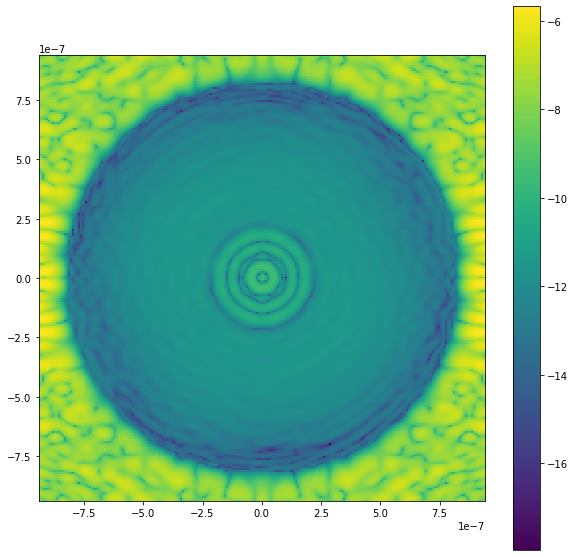

In [46]:
plt.figure(figsize=(10, 10))
hcipy.imshow_field(np.log(np.abs(focus_fieldS[89].electric_field)))
plt.colorbar()

In [125]:
luvoir_test = LuvoirA_APLC(optics_input, coronagraph_design, sampling)
luvoir_test.create_segmented_harris_mirror(filepath,pad_orientation, thermal = True,mechanical=False,other=False) 
luvoir_test.harris_sm

In [1]:
harris_mode = np.zeros(n_harris)
harris_mode[116] = nm_aber
luvoir_test.harris_sm.actuators  = harris_mode
hcipy.imshow_field(((10*luvoir_test.harris_sm.surface+1e-8*luvoir_segmented_pattern)))
plt.colorbar()

NameError: name 'np' is not defined

### Construct the PASTIS matrix from the E-fields

In [ ]:
mat_fast = np.zeros([n_harris, n_harris])   # create empty matrix

for i in range(0, n_harris):
    for j in range(0, n_harris):
        test = np.real((focus_fieldS[i].electric_field - Efield_ref) * np.conj(focus_fieldS[j].electric_field - Efield_ref))
        dh_test = (test / norm) * luvoir.dh_mask
        contrast = np.mean(dh_test[np.where(luvoir.dh_mask != 0)])
        mat_fast[i, j] = contrast

In [ ]:
matrix_pastis = np.copy(mat_fast)
matrix_pastis /= np.square(nm_aber * 1e9)

In [ ]:
plt.figure(figsize=(15,5))

#plt.subplot(1,2,1)
plt.imshow(np.log(np.abs(mat_fast)))
#plt.title("PASTIS matrix")
#plt.savefig('/Users/asahoo/Desktop/P_matrix.png')
#plt.colorbar()

# plt.subplot(1,2,2)
# plt.imshow(np.log(np.abs(matrix_pastis)))
# plt.title("np.log(np.abs(matrix_pastis))")
# plt.colorbar()

In [ ]:
filename_matrix = 'PASTISmatrix_n_harris_' + str(n_harris)
hcipy.write_fits(matrix_pastis, os.path.join(resDir, filename_matrix + '.fits'))
print('Matrix saved to:', os.path.join(resDir, filename_matrix + '.fits'))

In [ ]:
filename_matrix = 'EFIELD_Re_matrix_n_harris_' + str(n_harris)
hcipy.write_fits(focus_fieldS_Re, os.path.join(resDir, filename_matrix + '.fits'))
print('Efield Real saved to:', os.path.join(resDir, filename_matrix + '.fits'))

In [ ]:
filename_matrix = 'EFIELD_Im_matrix_n_harris_' + str(n_harris)
hcipy.write_fits(focus_fieldS_Im, os.path.join(resDir, filename_matrix + '.fits'))
print('Efield Imag saved to:', os.path.join(resDir, filename_matrix + '.fits'))

In [ ]:
end_time = time.time()

In [ ]:
print('Runtime for harris modes:', end_time - start_time, 'sec =', (end_time - start_time) / 60, 'min')
print('Data saved to {}'.format(resDir))

## error analysis

In [ ]:
evals, evecs = np.linalg.eig(matrix_pastis)
sorted_evals = np.sort(evals)
sorted_indices = np.argsort(evals)
sorted_evecs = evecs[:, sorted_indices]
plt.figure(figsize=(10, 10))
#plt.plot(evals, label='Unsorted from eigendecomposition')
plt.plot(sorted_evals)
plt.semilogy()
plt.xlabel('Mode Index')
plt.ylabel('Sensitivity of contrast for each mode')
plt.tick_params(top=True, bottom=True, left=True, right=True,
                labelleft=True, labelbottom=True)
#plt.legend()

In [ ]:
c_target_log = -11
c_target = 10**(c_target_log)
n_repeat = 20

In [ ]:
mu_map_harris = np.sqrt(((c_target) / (n_harris)) / (np.diag(matrix_pastis)))

In [ ]:
plt.figure(figsize=(20,5))
plt.title("Segment-based PASTIS constraints from PASTIS matrix and PASTIS modes")
plt.plot(mu_map_harris)


In [ ]:
sigma = np.sqrt(((c_target)) / (600 * sorted_evals))
plt.figure(figsize=(20,5))
plt.title("Max mode contribution(s) from the static-contrast target and eigen values")
plt.plot(sigma)

In [ ]:
cont_cum_pastis = []
for maxmode in range(sorted_evecs.shape[0]):
    
    aber = np.nansum(sorted_evecs[:, :maxmode+1] * sigma[:maxmode+1], axis=1)
    aber *= u.nm
    contrast_matrix = util.pastis_contrast(aber, matrix_pastis) + contrast_floor
    cont_cum_pastis.append(contrast_matrix)


In [ ]:
plt.figure(figsize=(10,10))
plt.plot(cont_cum_pastis)
plt.xlabel("modes")
plt.ylabel("List of cumulative contrast")

In [ ]:
cont_ind_pastis = []
for maxmode in range(sorted_evecs.shape[0]):
    aber = sorted_evecs[:, maxmode] * sigma[maxmode]
    aber *=u.nm
    contrast_matrix = util.pastis_contrast(aber, matrix_pastis)
    cont_ind_pastis.append(contrast_matrix)

In [ ]:
plt.figure(figsize=(20,10))
plt.plot((cont_ind_pastis))
plt.xlabel("modes")
plt.ylabel("List of Individual contrast")
plt.yscale('log')


In [ ]:
npup = np.int(np.sqrt(luvoir.pupil_grid.x.shape[0]))
nimg = np.int(np.sqrt(luvoir.focal_det.x.shape[0]))

# Getting the flux together
sptype = 'A0V' # Put this on config
Vmag = 0.0 # Put this in loop
minlam = 500 * u.nanometer # Put this on config
maxlam = 600 * u.nanometer # Put this on config
star_flux = exoscene.star.bpgs_spectype_to_photonrate(spectype=sptype, Vmag=Vmag, minlam=minlam.value, maxlam=maxlam.value)
Nph = star_flux.value*15**2*np.sum(luvoir.apodizer**2) / npup**2
dark_current = 0  #0.000072 #es per s 
CIC = 0.   #0.00076 #electrons per sec

In [ ]:
harris_mode = np.zeros(n_harris)
luvoir.harris_sm.actuators  = harris_mode
nonaberrated_coro_psf, refshit,inter_ref = luvoir.calc_psf(ref=True, display_intermediate=False, return_intermediate='efield',norm_one_photon=True)
Efield_ref = nonaberrated_coro_psf.electric_field

In [ ]:
harris_mode = np.zeros(n_harris)
luvoir.harris_sm.actuators  = harris_mode
harris_ref2 = luvoir.calc_out_of_band_wfs(norm_one_photon=True)
harris_ref2_sub_real = hcipy.field.subsample_field(harris_ref2.real, z_pup_downsample, grid_zernike, statistic='mean')
harris_ref2_sub_imag = hcipy.field.subsample_field(harris_ref2.imag, z_pup_downsample, grid_zernike, statistic='mean')
Efield_ref_OBWFS = (harris_ref2_sub_real + 1j*harris_ref2_sub_imag) * z_pup_downsample

In [ ]:
nyquist_sampling = 2.

# Actual grid for LUVOIR images
grid_test = hcipy.make_focal_grid(
            luvoir.sampling,
            luvoir.imlamD,
            pupil_diameter=luvoir.diam,
            focal_length=1,
            reference_wavelength=luvoir.wvln,
        )

# Actual grid for LUVOIR images that are nyquist sampled
grid_det_subsample = hcipy.make_focal_grid(
            nyquist_sampling,
            np.floor(luvoir.imlamD),
            pupil_diameter=luvoir.diam,
            focal_length=1,
            reference_wavelength=luvoir.wvln,
        )
n_nyquist = np.int(np.sqrt(grid_det_subsample.x.shape[0]))

In [ ]:
### Dark hole mask
design = 'medium'

dh_outer_nyquist = hcipy.circular_aperture(2 * luvoir.apod_dict[design]['owa'] * luvoir.lam_over_d)(grid_det_subsample)
dh_inner_nyquist = hcipy.circular_aperture(2 * luvoir.apod_dict[design]['iwa'] * luvoir.lam_over_d)(grid_det_subsample)
dh_mask_nyquist = (dh_outer_nyquist - dh_inner_nyquist).astype('bool')

dh_size = len(np.where(luvoir.dh_mask != 0)[0])
dh_size_nyquist = len(np.where(dh_mask_nyquist != 0)[0])
dh_index = np.where(luvoir.dh_mask != 0)[0]
dh_index_nyquist = np.where(dh_mask_nyquist != 0)[0]

In [ ]:
# E0_LOWFS = np.zeros([N_pup_z*N_pup_z,1,2])
# E0_LOWFS[:,0,0] = Efield_ref_LOWFS.real
# E0_LOWFS[:,0,1] = Efield_ref_LOWFS.imag
E0_OBWFS = np.zeros([N_pup_z*N_pup_z,1,2])
E0_OBWFS[:,0,0] = Efield_ref_OBWFS.real
E0_OBWFS[:,0,1] = Efield_ref_OBWFS.imag
E0_coron = np.zeros([nimg*nimg,1,2])
E0_coron[:,0,0] = Efield_ref.real
E0_coron[:,0,1] = Efield_ref.imag
E0_coron_nyquist = np.zeros([n_nyquist*n_nyquist,1,2])
tmp0 = hcipy.interpolation.make_linear_interpolator_separated(Efield_ref, grid=grid_test)
Efield_ref_nyquist = (luvoir.sampling/nyquist_sampling)**2*tmp0(grid_det_subsample)
E0_coron_nyquist[:,0,0] = Efield_ref_nyquist.real
E0_coron_nyquist[:,0,1] = Efield_ref_nyquist.imag
E0_coron_DH = np.zeros([dh_size,1,2])
E0_coron_DH[:,0,0] = Efield_ref.real[dh_index]
E0_coron_DH[:,0,1] = Efield_ref.imag[dh_index]
E0_coron_DH_nyquist = np.zeros([dh_size_nyquist,1,2])
E0_coron_DH_nyquist[:,0,0] = Efield_ref_nyquist.real[dh_index_nyquist]
E0_coron_DH_nyquist[:,0,1] = Efield_ref_nyquist.real[dh_index_nyquist]

In [ ]:
filename_matrix = 'EFIELD_Re_matrix_n_harris_' + str(n_harris) + '.fits'
G_harris_real = fits.getdata(os.path.join(overall_dir, 'matrix_numerical', filename_matrix))
filename_matrix = 'EFIELD_Im_matrix_n_harris_' + str(n_harris) + '.fits'
G_harris_imag = fits.getdata(os.path.join(overall_dir, 'matrix_numerical', filename_matrix))

G_coron_harris_nyquist= np.zeros([n_nyquist*n_nyquist,2,n_harris])
for pp in range(0, n_harris):
    tmp0 = G_harris_real[pp] + 1j*G_harris_imag[pp]
    tmp1 = hcipy.interpolation.make_linear_interpolator_separated(tmp0, grid=grid_test)
    tmp2 = (luvoir.sampling/nyquist_sampling)**2*tmp1(grid_det_subsample)
    G_coron_harris_nyquist[:,0,pp] = tmp2.real - Efield_ref_nyquist.real
    G_coron_harris_nyquist[:,1,pp] = tmp2.real - Efield_ref_nyquist.imag

In [ ]:
G_coron_harris_DH= np.zeros([dh_size,2,n_harris])
for pp in range(0, n_harris):
    G_coron_harris_DH[:,0,pp] = G_harris_real[pp,dh_index] - Efield_ref.real[dh_index]
    G_coron_harris_DH[:,1,pp] = G_harris_imag[pp,dh_index] - Efield_ref.imag[dh_index]

In [ ]:
G_coron_harris_DH_nyquist= np.zeros([dh_size_nyquist,2,n_harris])
for pp in range(0, n_harris):
    tmp0 = G_harris_real[pp] + 1j*G_harris_imag[pp]
    tmp1 = hcipy.interpolation.make_linear_interpolator_separated(tmp0, grid=grid_test)
    tmp2 = (luvoir.sampling/nyquist_sampling)**2*tmp1(grid_det_subsample)
    G_coron_harris_DH_nyquist[:,0,pp-1] = tmp2.real[dh_index_nyquist] - Efield_ref_nyquist.real[dh_index_nyquist]
    G_coron_harris_DH_nyquist[:,1,pp-1] = tmp2.real[dh_index_nyquist] - Efield_ref_nyquist.imag[dh_index_nyquist]

In [ ]:
G_coron_harris= np.zeros([nimg*nimg,2,n_harris])
for pp in range(0, n_harris):
    G_coron_harris[:,0,pp] = G_harris_real[pp] - Efield_ref.real
    G_coron_harris[:,1,pp] = G_harris_imag[pp] - Efield_ref.imag

In [ ]:
start_time = time.time()
focus_fieldS = []
focus_fieldS_Re = []
focus_fieldS_Im = []

In [ ]:
for pp in range(0, n_harris):
    print(pp)
    harris_modes = np.zeros(n_harris)
    harris_modes[pp] = (nm_aber) / 2
    luvoir.harris_sm.actuators  = harris_mode
    harris_meas = luvoir.calc_out_of_band_wfs(norm_one_photon=True)
    harris_meas_sub_real = hcipy.field.subsample_field(harris_meas.real, z_pup_downsample, grid_zernike, statistic='mean')
    harris_meas_sub_imag = hcipy.field.subsample_field(harris_meas.imag, z_pup_downsample, grid_zernike, statistic='mean')
    focus_field1 = harris_meas_sub_real + 1j * harris_meas_sub_imag
    focus_fieldS.append(focus_field1)
    focus_fieldS_Re.append(focus_field1.real)
    focus_fieldS_Im.append(focus_field1.imag)

In [ ]:
filename_matrix = 'EFIELD_OBWFS_Re_matrix_num_harris_' + str(n_harris)
hcipy.write_fits(focus_fieldS_Re, os.path.join(resDir, filename_matrix + '.fits'))
print('Efield Real saved to:', os.path.join(resDir, filename_matrix + '.fits'))

filename_matrix = 'EFIELD_OBWFS_Im_matrix_num_harris_' + str(n_harris)
hcipy.write_fits(focus_fieldS_Im, os.path.join(resDir, filename_matrix + '.fits'))
print('Efield Imag saved to:', os.path.join(resDir, filename_matrix + '.fits'))

In [ ]:
filename_matrix = 'EFIELD_OBWFS_Re_matrix_num_harris_' + str(n_harris)+'.fits'
G_OBWFS_real = fits.getdata(os.path.join(overall_dir, 'matrix_numerical', filename_matrix))
filename_matrix = 'EFIELD_OBWFS_Im_matrix_num_harris_' + str(n_harris)+'.fits'
G_OBWFS_imag =  fits.getdata(os.path.join(overall_dir, 'matrix_numerical', filename_matrix))

In [ ]:
G_OBWFS= np.zeros([N_pup_z*N_pup_z,2,n_harris])
for pp in range(0, n_harris):
    G_OBWFS[:,0,pp] = G_OBWFS_real[pp]*z_pup_downsample - Efield_ref_OBWFS.real
    G_OBWFS[:,1,pp] = G_OBWFS_imag[pp]*z_pup_downsample - Efield_ref_OBWFS.imag

In [ ]:
def req_closedloop_calc_recursive(Gcoro, Gsensor, E0coro, E0sensor, Dcoro, Dsensor, t_exp, flux, Q, Niter, dh_mask,
                                  norm):
    P = np.zeros(Q.shape)  # WFE modes covariance estimate
    r = Gsensor.shape[2]
    N = Gsensor.shape[0]
    N_img = Gcoro.shape[0]
    c = 1
    # Iterations of ALGORITHM 1
    contrast_hist = np.zeros(Niter)
    intensity_WFS_hist = np.zeros(Niter)
    cal_I_hist = np.zeros(Niter)
    eps_hist = np.zeros([Niter, r])
    averaged_hist = np.zeros(Niter)
    contrasts = []
    for pp in range(Niter):
        eps = np.random.multivariate_normal(np.zeros(r), P + Q * t_exp).reshape((1, 1, r))  # random modes
        G_eps = np.sum(Gsensor * eps, axis=2).reshape((N, 1, 2 * c)) + E0sensor  # electric field
        G_eps_squared = np.sum(G_eps * G_eps, axis=2, keepdims=True)
        G_eps_G = np.matmul(G_eps, Gsensor)
        G_eps_G_scaled = G_eps_G / np.sqrt(G_eps_squared + Dsensor / flux / t_exp)  # trick to save RAM
        cal_I = 4 * flux * t_exp * np.einsum("ijk,ijl->kl", G_eps_G_scaled, G_eps_G_scaled)  # information matrix
        P = np.linalg.inv(np.linalg.inv(P + Q * t_exp / 2) + cal_I)
        #         P = np.linalg.inv(cal_I)

        # Coronagraph
        G_eps_coron = np.sum(Gcoro * eps, axis=2).reshape((N_img, 1, 2 * c)) + E0coro
        G_eps_coron_squared = np.sum(G_eps_coron * G_eps_coron, axis=2, keepdims=True)
        intensity = G_eps_coron_squared * flux * t_exp + Dcoro

        # Wavefront sensor
        intensity_WFS = G_eps_squared * flux * t_exp + Dsensor

        # Archive
        test_DH0 = intensity[:, 0, 0] * luvoir.dh_mask
        test_DH = np.mean(test_DH0[np.where(test_DH0 != 0)])
        contrasts.append(test_DH / flux / t_exp / norm)
        intensity_WFS_hist[pp] = np.sum(intensity_WFS) / flux
        cal_I_hist[pp] = np.mean(cal_I) / flux
        eps_hist[pp] = eps
        averaged_hist[pp] = np.mean(contrasts)
        #         print("est. contrast", np.mean(contrasts))

        outputs = {'intensity_WFS_hist': intensity_WFS_hist,
                   'cal_I_hist': cal_I_hist,
                   'eps_hist': eps_hist,
                   'averaged_hist': averaged_hist,
                   'contrasts': contrasts}
    return outputs

In [ ]:
def req_closedloop_calc_batch(Gcoro, Gsensor, E0coro, E0sensor, Dcoro, Dsensor, t_exp, flux, Q, Niter, dh_mask, norm):
    P = np.zeros(Q.shape)  # WFE modes covariance estimate
    r = Gsensor.shape[2]
    N = Gsensor.shape[0]
    N_img = Gcoro.shape[0]
    c = 1
    # Iterations of ALGORITHM 1
    contrast_hist = np.zeros(Niter)
    intensity_WFS_hist = np.zeros(Niter)
    cal_I_hist = np.zeros(Niter)
    eps_hist = np.zeros([Niter, r])
    averaged_hist = np.zeros(Niter)
    contrasts = []
    for pp in range(Niter):
        eps = np.random.multivariate_normal(np.zeros(r), P + Q * t_exp).reshape((1, 1, r))  # random modes
        G_eps = np.sum(Gsensor * eps, axis=2).reshape((N, 1, 2 * c)) + E0sensor  # electric field
        G_eps_squared = np.sum(G_eps * G_eps, axis=2, keepdims=True)
        G_eps_G = np.matmul(G_eps, Gsensor)
        G_eps_G_scaled = G_eps_G / np.sqrt(G_eps_squared + Dsensor / flux / t_exp)  # trick to save RAM
        cal_I = 4 * flux * t_exp * np.einsum("ijk,ijl->kl", G_eps_G_scaled, G_eps_G_scaled)  # information matrix
        #         P = np.linalg.inv(np.linalg.inv(P+Q*t_exp/2) + cal_I)
        P = np.linalg.pinv(cal_I)

        # Coronagraph
        G_eps_coron = np.sum(Gcoro * eps, axis=2).reshape((N_img, 1, 2 * c)) + E0coro
        G_eps_coron_squared = np.sum(G_eps_coron * G_eps_coron, axis=2, keepdims=True)
        intensity = G_eps_coron_squared * flux * t_exp + Dcoro

        # Wavefront sensor
        intensity_WFS = G_eps_squared * flux * t_exp + Dsensor

        # Archive
        test_DH0 = intensity[:, 0, 0] * luvoir.dh_mask
        test_DH = np.mean(test_DH0[np.where(test_DH0 != 0)])
        contrasts.append(test_DH / flux / t_exp / norm)
        intensity_WFS_hist[pp] = np.sum(intensity_WFS) / flux
        cal_I_hist[pp] = np.mean(cal_I) / flux
        eps_hist[pp] = eps
        averaged_hist[pp] = np.mean(contrasts)
    #         print("est. contrast", np.mean(contrasts))
    #         print("est. contrast", np.mean(contrasts))

    outputs = {'intensity_WFS_hist': intensity_WFS_hist,
               'cal_I_hist': cal_I_hist,
               'eps_hist': eps_hist,
               'averaged_hist': averaged_hist,
               'contrasts': contrasts}

    return outputs


In [ ]:
flux = Nph
Qharris = np.diag(np.asarray(mu_map_harris**2))

In [ ]:
# Running a bunch of tests for time series

Ntimes = 20
TimeMinus = -2
TimePlus = 3.5
Nwavescale = 8
WaveScaleMinus = -2
WaveScalePlus = 1
Nflux = 3
fluxPlus = 10
fluxMinus = 0

timeVec = np.logspace(TimeMinus,TimePlus,Ntimes)
WaveVec = np.logspace(WaveScaleMinus,WaveScalePlus,Nwavescale)
fluxVec = np.linspace(fluxMinus,fluxPlus,Nflux)
wavescaleVec = np.logspace(WaveScaleMinus,WaveScalePlus,Nwavescale)

In [ ]:
niter = 10
print('harris modes with batch OBWFS and noise')

timer1 = time.time()
wavescale = 1.
StarMag = 1.0
result_1 = []
for tscale in np.logspace(TimeMinus, TimePlus, Ntimes):
        Starfactor = 10**(-StarMag/2.5)
        print(tscale)
        tmp0 = req_closedloop_calc_batch(G_coron_harris, G_OBWFS, E0_coron, E0_OBWFS, dark_current+CIC/tscale,
                                             dark_current+CIC/tscale, tscale, flux*Starfactor, wavescale**2*Qharris,
                                             niter, luvoir.dh_mask, norm)    
        tmp1 = tmp0['averaged_hist']
        n_tmp1 = len(tmp1)
        result_1.append(tmp1[n_tmp1-1])
        
timer2 = time.time()
print(timer2 - timer1)

In [ ]:
plt.figure(figsize=(35,10))

# plt.rcParams["font.size"] = 16
# plt.rcParams["axes.labelsize"] = 22
# plt.rcParams["axes.labelweight"] = "bold"
# plt.rcParams["xtick.labelsize"] = 16
# plt.rcParams["ytick.labelsize"] = 16
# plt.rcParams["legend.fontsize"] = 16
# plt.rcParams["figure.titlesize"] = 16

plt.subplot(1,3,1)
plt.title("Faceplates Silvered")
hcipy.imshow_field((nu_maps[0])*1e12, cmap = 'RdBu',vmin=-15, vmax=15)
cbar = plt.colorbar()
cbar.set_label("pm")

plt.subplot(1,3,2)
plt.title("Bulk")
hcipy.imshow_field((nu_maps[1])*1e12, cmap = 'RdBu',vmin=-25, vmax=5)
cbar = plt.colorbar()
cbar.set_label("pm")

plt.subplot(1,3,3)
plt.title("Gradient Radial")
hcipy.imshow_field((nu_maps[2])*1e12, cmap = 'RdBu',vmin=-15, vmax=15)
cbar = plt.colorbar()
cbar.set_label("pm")



In [ ]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.title("Segment Level 1mk gradient X lateral")
hcipy.imshow_field((nu_maps[3])*1e12, cmap = 'RdBu',vmin=-10, vmax=10)
cbar = plt.colorbar()
cbar.set_label("pm")

plt.subplot(1,2,2)
plt.title("Segment level 1mk gradient Z axial")
hcipy.imshow_field((nu_maps[4])*1e12,cmap = 'RdBu',vmin=-15, vmax=15)
cbar = plt.colorbar()
cbar.set_label("pm")

In [ ]:
five_vec_1 = np.zeros(120)
five_vec_2 = np.zeros(120)
five_vec_3 = np.zeros(120)
five_vec_4 = np.zeros(120)
five_vec_5 = np.zeros(120)

j = -1
for i in range (0,596,5):
        j = j+1
        print("i---",i,"j---",j) 
        five_vec_1[j]=mu_map_harris[i]
        five_vec_2[j]=mu_map_harris[i+1]
        five_vec_3[j]=mu_map_harris[i+2]
        five_vec_4[j]=mu_map_harris[i+3]
        five_vec_5[j]=mu_map_harris[i+4]

In [ ]:
luvoir2 = LuvoirA_APLC(optics_input, coronagraph_design, sampling)
luvoir2.create_segmented_mirror(1)
luvoir2.sm.actuators = five_vec_1

luvoir3 = LuvoirA_APLC(optics_input, coronagraph_design, sampling)
luvoir3.create_segmented_mirror(1)
luvoir3.sm.actuators = five_vec_2

luvoir4 = LuvoirA_APLC(optics_input, coronagraph_design, sampling)
luvoir4.create_segmented_mirror(1)
luvoir4.sm.actuators = five_vec_3


luvoir5 = LuvoirA_APLC(optics_input, coronagraph_design, sampling)
luvoir5.create_segmented_mirror(1)
luvoir5.sm.actuators = five_vec_4


luvoir6 = LuvoirA_APLC(optics_input, coronagraph_design, sampling)
luvoir6.create_segmented_mirror(1)
luvoir6.sm.actuators = five_vec_5

In [ ]:
plt.figure(figsize =(35,10))

plt.subplot(1,3,1)
plt.title("Segment Level 1mk Faceplates Silvered")
hcipy.imshow_field((luvoir2.sm.surface)*1000, cmap = 'RdBu')
cbar = plt.colorbar()
cbar.set_label("mK")

plt.subplot(1,3,2)
plt.title("Segment Level 1mk bulk")
hcipy.imshow_field((luvoir3.sm.surface)*1000, cmap = 'RdBu')
cbar = plt.colorbar()
cbar.set_label("mK")

plt.subplot(1,3,3)
plt.title("Segment Level 1mk gradient radial")
hcipy.imshow_field((luvoir4.sm.surface)*1000, cmap = 'RdBu')
cbar = plt.colorbar()
cbar.set_label("mK")




In [ ]:
plt.figure(figsize =(25,10))

plt.subplot(1,2,1)
plt.title("Segment Level 1mk gradient X lateral ")
hcipy.imshow_field((luvoir5.sm.surface)*1000, cmap = 'RdBu')
cbar = plt.colorbar()
cbar.set_label("mK")

plt.subplot(1,2,2)
plt.title("Segment level 1mk gradient Z axial")
hcipy.imshow_field((luvoir6.sm.surface)*1000, cmap = 'RdBu')
cbar = plt.colorbar()
cbar.set_label("mK")

In [ ]:
five_vec_1?

In [ ]:
# niter = 3
# print('harris modes with batch OBWFS and noise')

# timer1 = time.time()


# res = np.zeros([Ntimes, Nwavescale, Nflux, 1])
# pp = 0
# for tscale in np.logspace(TimeMinus, TimePlus, Ntimes):
#     qq = 0
#     print(tscale)
#     for wavescale in np.logspace(WaveScaleMinus, WaveScalePlus, Nwavescale):
#         rr = 0
#         for StarMag in np.linspace(fluxMinus, fluxPlus, Nflux):
#             Starfactor = 10**(-StarMag/2.5)
#             tmp0 = req_closedloop_calc_batch(G_coron_harris, G_OBWFS, E0_coron, E0_OBWFS, dark_current+CIC/tscale,
#                                              dark_current+CIC/tscale, tscale, flux*Starfactor, wavescale**2*Qharris,
#                                              niter, luvoir.dh_mask, norm)
#             tmp1 = tmp0['averaged_hist']
#             n_tmp1 = len(tmp1)
#             res[pp,qq,rr] =  np.mean(tmp1[np.int(n_tmp1/2):n_tmp1]) - contrast_floor
#             rr = rr + 1
#         qq = qq + 1
#     pp = pp + 1

In [ ]:
# res_line = np.reshape(res,[Ntimes*Nwavescale*Nflux])
# text_files_name = os.path.join(overall_dir, f'harris_OBWFS_Batch_dark_{dark_current}_CIC_{CIC}.csv')
# np.savetxt(text_files_name, res_line, delimiter=",")

# timer2 = time.time()
# print(timer2 - timer1)


# print('harris modes with recursive OBWFS and noise')

# timer1 = time.time()


# res = np.zeros([Ntimes, Nwavescale, Nflux, 1])
# pp = 0
# for tscale in np.logspace(TimeMinus, TimePlus, Ntimes):
#     qq = 0
#     print(tscale)
#     for wavescale in np.logspace(WaveScaleMinus, WaveScalePlus, Nwavescale):
#         rr = 0
#         for StarMag in np.linspace(fluxMinus,fluxPlus,Nflux):
#             Starfactor = 10**(-StarMag/2.5)
#             tmp0 = req_closedloop_calc_recursive(G_coron_harris, G_OBWFS, E0_coron, E0_OBWFS, dark_current+CIC/tscale,
#                                                  dark_current+CIC/tscale, tscale, flux*Starfactor, wavescale**2*Qharris,
#                                                  niter, luvoir.dh_mask, norm)
#             tmp1 = tmp0['averaged_hist']
#             n_tmp1 = len(tmp1)
#             res[pp,qq,rr] =  np.mean(tmp1[np.int(n_tmp1/2):n_tmp1]) - contrast_floor
#             rr = rr + 1
#         qq = qq + 1
#     pp = pp + 1

In [ ]:
luvoir2.sm.surface?

In [ ]:
# wf_active_pupil = wf_aper
# wf_active_pupil = harris_sm(wf_active_pupil)
# wf_harris_sm = harris_sm(wf_aper)

# hcipy.imshow_field(wf_active_pupil.phase)
# hcipy.imshow_field(wf_harris_sm.phase)
# hcipy.imshow_field(wf_aper.phase)

# # All E-field propagations
# wf_dm1_coro = hcipy.Wavefront(wf_active_pupil.electric_field * np.exp(4 * 1j * np.pi/wvln * self.DM1), self.wavelength)
# wf_dm2_coro_before = fresnel(wf_dm1_coro)
# wf_dm2_coro_after = hcipy.Wavefront(wf_dm2_coro_before.electric_field * np.exp(4 * 1j * np.pi / self.wavelength * self.DM2) * self.DM2_circle, self.wavelength)
# wf_back_at_dm1 = self.fresnel_back(wf_dm2_coro_after)
# wf_apod_stop = hcipy.Wavefront(wf_back_at_dm1.electric_field * self.apod_stop, self.wavelength)

# wf_before_lyot = self.coro(wf_apod_stop)
# wf_lyot = self.lyot_stop(wf_before_lyot)
# wf_lyot.wavelength = self.wavelength

# wf_im_coro = self.prop(wf_lyot)
# wf_im_ref = self.prop(wf_back_at_dm1)